In [2]:
import torch
import numpy as np
np.random.seed(42)

import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from dynamics import*
from utils import*

# Numerical settings - Shallow water parameters

In [3]:
# --------------- Physical prameters ---------------
L_x = 1E+6              # Length of domain in x-direction
L_y = 1E+6              # Length of domain in y-direction
g = 9.81                # Acceleration of gravity [m/s^2]
H = 100                 # Depth of fluid [m]

# --------------- Computational prameters ---------------
N_x = 64                            # Number of grid points in x-direction
N_y = 64                            # Number of grid points in y-direction
dx = L_x/(N_x - 1)                  # Grid spacing in x-direction
dy = L_y/(N_y - 1)

x = torch.linspace(-L_x/2, L_x/2, N_x)  # Array with x-points
y = torch.linspace(-L_y/2, L_y/2, N_y)  # Array with y-points
Xx, Yy = torch.meshgrid(x, y) 

# Initial conditions

../utils/velcolor.py:57: RuntimeWarning: invalid value encountered in true_divide
  U /= 2*np.max(rad)
../utils/velcolor.py:58: RuntimeWarning: invalid value encountered in true_divide
  V /= 2*np.max(rad)
../utils/velcolor.py:74: RuntimeWarning: invalid value encountered in less_equal
  idx = rad <=1


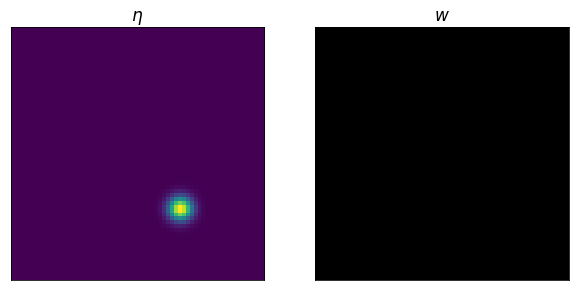

In [4]:
# --------------- random initial conditions ---------------
xx=np.random.uniform(3,7,1)*np.random.choice([-1,1], size=1, p=[0.5, 0.5])
yy=np.random.uniform(3,7,1)*np.random.choice([-1,1], size=1, p=[0.5, 0.5])
s=np.random.uniform(2,10,1)*1E+4

X0=torch.zeros((3,N_x,N_y))
X0[0,:,:]=5*torch.exp(-((Xx-L_x/xx)**2/(2*(s)**2) + (Yy-L_y/yy)**2/(2*(s)**2)))

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(X0[0,:,:])
plt.title('$\eta$',fontsize=17)
plt.yticks([])
plt.xticks([])
    
plt.subplot(1,2,2)
plot_w(X0[1,:,:], X0[2,:,:], quiver=True)
plt.title('$w$',fontsize=17)
plt.show()

# 1st Integration - generate initial conditions

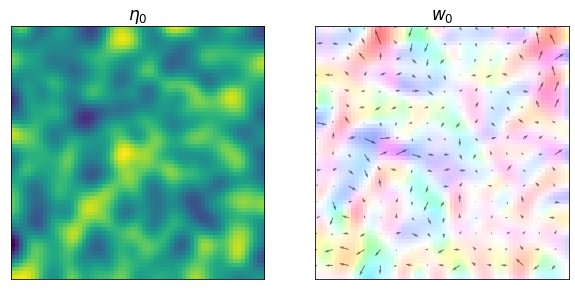

In [5]:
# --------------- Dynamics ---------------
dynamics=SW(dx=dx, dy=dy)

# --------------- run up ---------------
for t in range(1000):
    
    X0=dynamics.forward(X0)

eta0_truth=X0[0,:,:]
w0_truth=X0[1:,:,:]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(eta0_truth)
plt.title('$\eta_{0}$',fontsize=17)
plt.yticks([])
plt.xticks([])

plt.subplot(1,2,2)
plot_w(w0_truth[0,:,:], w0_truth[1,:,:], quiver=True,q_scale=2.5)
plt.title('$w_{0}$',fontsize=17)
plt.show()

# 2nd Integration - generate trajectory

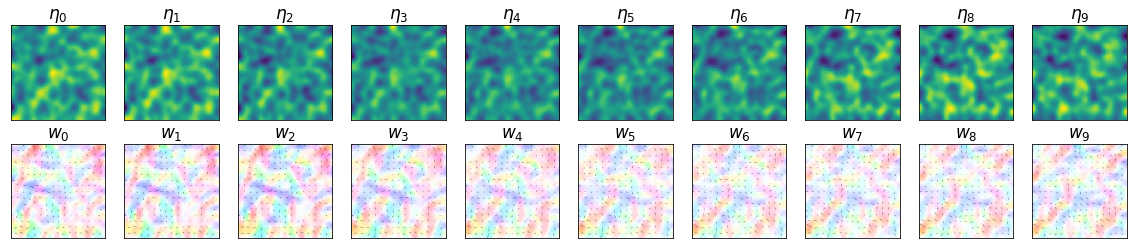

In [6]:
T=10    # Assimilation window size
subsample=3    # Subsampling frequency
sigma=0.1    # white noise std

# Storage arrays
X = X0
Obs = torch.zeros((T,X0.shape[0],X0.shape[1],X0.shape[2]))

# integrate, subsample, add noise
plt.figure(figsize=(20,4))

for t in range(T):
    
    if t%subsample==0:
        
        noise=torch.normal(0,sigma,X.shape)
        Obs[t,0,:,:] = X[0,:,:]+noise[0,:,:]
        #Rm1[t,0,:,:] = torch.ones(X[0,:,:].shape)
        
    plt.subplot(2,T,t+1)
    plt.title('$\eta_{'+str(t)+'}$',fontsize=17)
    plt.yticks([])
    plt.xticks([])

    plt.imshow(X[0,:,:])
    plt.subplot(2,T,T+t+1)
    plot_w(X[1,:,:],X[2,:,:],quiver=True,title='w_'+str(t),q_scale=2.5)
    plt.title('$w_{'+str(t)+'}$',fontsize=17)
    
    X=dynamics.forward(X)


#plt.savefig('../figures/trajectory.pdf',bbox_inches='tight')
plt.show()

# Add noise & sample - generate Observations

/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/arthur_lip6/Library/Python/3.7/lib/python/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


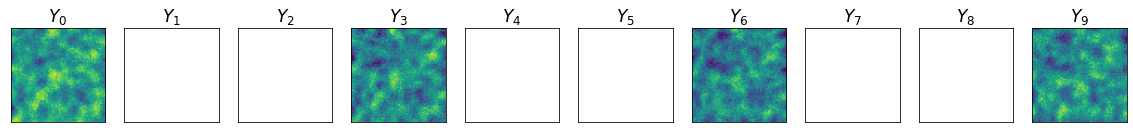

In [7]:
plt.figure(figsize=(20,4))

for t in range(T):
        
    plt.subplot(1,T,t+1)
    plt.title('$Y_{'+str(t)+'}$',fontsize=17)
    if t%subsample==0:
        plt.imshow(Obs[t,0,:])
    else :
        plt.imshow(float('Nan')*Obs[t,0,:])
    plt.yticks([])
    plt.xticks([])

    #plt.subplot(2,T,T+t+1)
    #plot_w(Obs[t,1,:],Obs[t,2,:],quiver=True,title='w_'+str(t),q_scale=2.5)
    #plt.title('$w_{'+str(t)+'}$',fontsize=17)


#plt.savefig('../figures/observations.pdf',bbox_inches='tight')
plt.show()

# Encapsulate in DataGenerator class - generate Dataset

In [14]:
generator=DataGenerator(dynamics,T=10,subsample=3,sigma=0.05)
initial_condition, Obs = generator.sample()

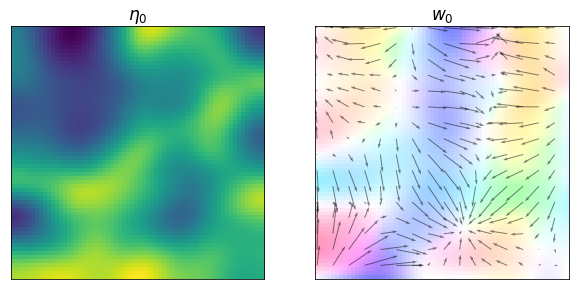

In [15]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(initial_condition[0,:,:])
plt.title('$\eta_0$',fontsize=17)
plt.yticks([])
plt.xticks([])
    
plt.subplot(1,2,2)
initial_condition=torch.Tensor(initial_condition)
plot_w(initial_condition[2,:,:], initial_condition[1,:,:], quiver=True,q_scale=2.5)
plt.title('$w_0$',fontsize=17)
plt.show()

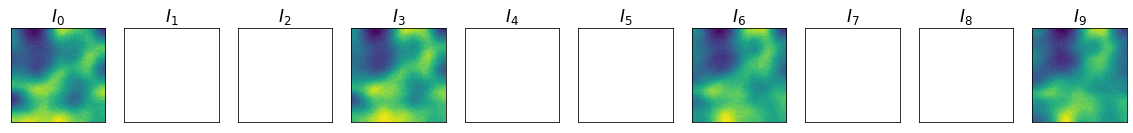

In [16]:
plt.figure(figsize=(20,4))

for t in range(T):
        
    plt.subplot(1,T,t+1)
    plt.title('$I_{'+str(t)+'}$',fontsize=17)
    if t%subsample==0:
        plt.imshow(Obs[t,0,:])
    else :
        plt.imshow(float('Nan')*Obs[t,0,:])
    plt.yticks([])
    plt.xticks([])

    #plt.subplot(2,T,T+t+1)
    #plot_w(Obs[t,1,:],Obs[t,2,:],quiver=True,title='w_'+str(t),q_scale=2.5)
    #plt.title('$w_{'+str(t)+'}$',fontsize=17)


plt.show()

In [10]:
# generate dataset
#n_sample=1000

#if not os.path.exists('../data'):
    #os.makedirs('../data')

#root_dir='../data/generated/'
#generator.dataset(n_sample, root_dir)